In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ISC Case study/Data/pre_processed_dataset_balanced.csv')

In [ ]:
df.head()

,age,income_level,fico_score,delinquency_status,number_of_credit_applications,debt_to_income_ratio,payment_methods_high_risk,max_balance,avg_balance_last_12months,number_of_delinquent_accounts,...,multiple_applications_short_time_period,unusual_submission_pattern,applications_submitted_during_odd_hours,watchlist_blacklist_flag,public_records_flag,account_age_days,credit_history_length,location_encoded,occupation_encoded,charge_off_status
0,33,48454,719.0,0,1,1.270638,0,93981.64798,55407.52161,0,...,0,0,0,0,0,1274,566,1,6,0
1,20,52467,404.0,94,8,1.549684,1,30633.91286,11975.53474,3,...,1,1,0,0,0,813,380,1,10,1
2,62,5777,790.0,0,1,2.536890,1,88730.55986,54101.28209,0,...,1,0,0,0,0,1393,3037,3,7,0
3,28,8715,530.0,0,1,1.612346,0,51115.72509,35304.13972,1,...,0,0,1,0,0,948,2887,8,7,0
4,40,23440,624.0,0,1,0.918553,0,66592.17178,42156.14981,0,...,0,0,0,0,0,108,882,9,10,0


In [4]:
X = df.drop('charge_off_status', axis = 1)
y = df['charge_off_status']

In [5]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [6]:
model_path = '/content/drive/MyDrive/ISC Case study/Data/logit_model.pkl'

with open(model_path, 'rb') as model_file:
    logit_model = pickle.load(model_file)

# Verify the model type
type(logit_model)

sklearn.linear_model._logistic.LogisticRegression

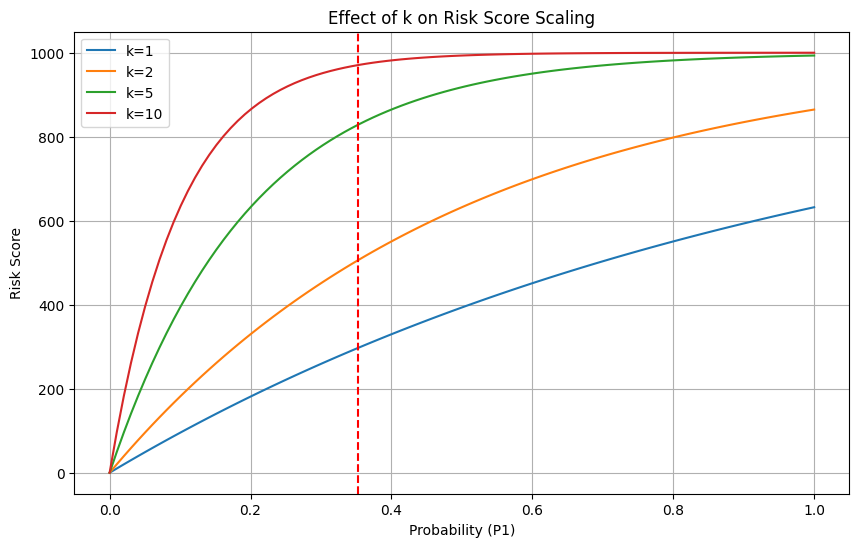

Optimal k value: 1.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Sample probabilities (P1 values)
P1 = np.linspace(0, 1, 100)  # Example probabilities from 0 to 1

# Function to calculate risk score
def risk_score(P1, k):
    return 1000 * (1 - np.exp(-k * P1))

# Test different k values
k_values = [1,2,5,10]
risk_scores = {k: risk_score(P1, k) for k in k_values}

# Plot risk scores for different k
plt.figure(figsize=(10, 6))
for k, scores in risk_scores.items():
    plt.plot(P1, scores, label=f'k={k}')

# Add vertical line at x=0.5
plt.axvline(x=0.352, color='red', linestyle='--')

plt.title('Effect of k on Risk Score Scaling')
plt.xlabel('Probability (P1)')
plt.ylabel('Risk Score')
plt.legend()
plt.grid()
plt.show()

# Example: Optimize k for maximum AUC-ROC
# Simulated true labels and probabilities
true_labels = np.random.choice([0, 1], size=100, p=[0.7, 0.3])
predicted_probs = np.random.rand(100)

# Test k values and calculate AUC for each
auc_scores = []
for k in np.linspace(1, 10, 50):
    scores = risk_score(predicted_probs, k)
    auc = roc_auc_score(true_labels, scores)
    auc_scores.append((k, auc))

# Find k with the best AUC
best_k = max(auc_scores, key=lambda x: x[1])[0]
print(f'Optimal k value: {best_k}')

In [7]:
probabilities = logit_model.predict_proba(X_train)

# Extract probabilities for class 1 (charged off)
P1_all = probabilities[:, 1]
P0_all = probabilities[:, 0]

P1_all


array([0.21093844, 0.93661774, 0.90986629, ..., 0.65052341, 0.39748785,
       0.33871895])

Optimal Cutoff Probability: 0.35291800790989536


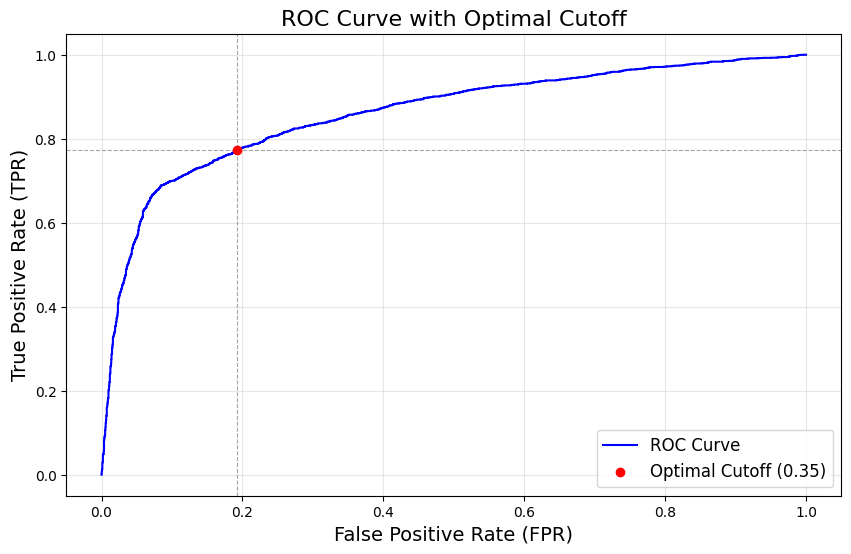

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Assuming y_train and prob_train are already defined
# y_train: True labels for the training set
# prob_train: Predicted probabilities for the positive class (e.g., from logistic regression)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, P1_all)

# Calculate distances to the top-left corner (0,1)
distance = np.sqrt((1 - tpr)**2 + fpr**2)

# Find the index of the optimal threshold
optimal_index = np.argmin(distance)
optimal_cutoff = thresholds[optimal_index]
print(f"Optimal Cutoff Probability: {optimal_cutoff}")

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="ROC Curve", color='blue')
plt.scatter(fpr[optimal_index], tpr[optimal_index], color='red', label=f'Optimal Cutoff ({optimal_cutoff:.2f})', zorder=5)

# Add labels and title
plt.title("ROC Curve with Optimal Cutoff", fontsize=16)
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
plt.axvline(fpr[optimal_index], color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
plt.axhline(tpr[optimal_index], color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# Add grid and legend
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Display the plot
plt.show()


In [8]:
from sklearn.metrics import precision_recall_curve, f1_score

# Generate precision-recall data
precision, recall, thresholds = precision_recall_curve(y_train, P1_all)

# Calculate F1-scores
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold with the highest F1-score
optimal_index = np.argmax(f1_scores)
optimal_cutoff = thresholds[optimal_index]
print(f"Optimal Cutoff Probability (F1-Score): {optimal_cutoff}")


Optimal Cutoff Probability (F1-Score): 0.3331368823887953


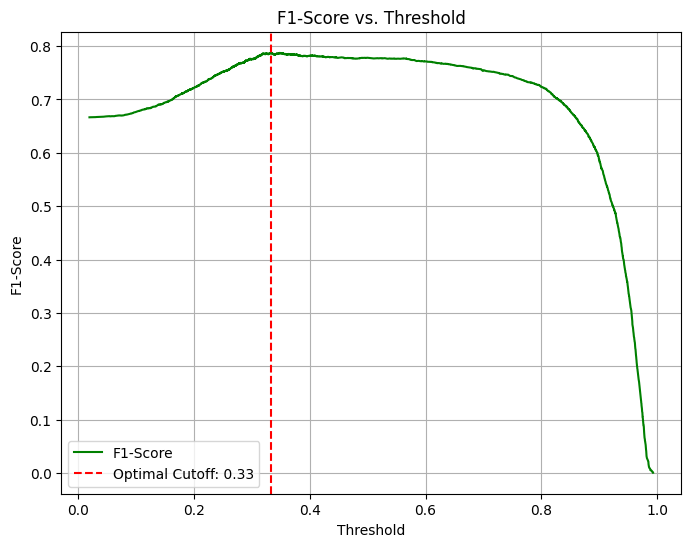

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1-Score', color='green')
plt.axvline(optimal_cutoff, color='red', linestyle='--', label=f'Optimal Cutoff: {optimal_cutoff:.2f}')
plt.title('F1-Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.legend()
plt.grid()
plt.show()


#####

#Simulation method


In [9]:
P1_all

array([0.21093844, 0.93661774, 0.90986629, ..., 0.65052341, 0.39748785,
       0.33871895])

effective k: 2.484848484848485


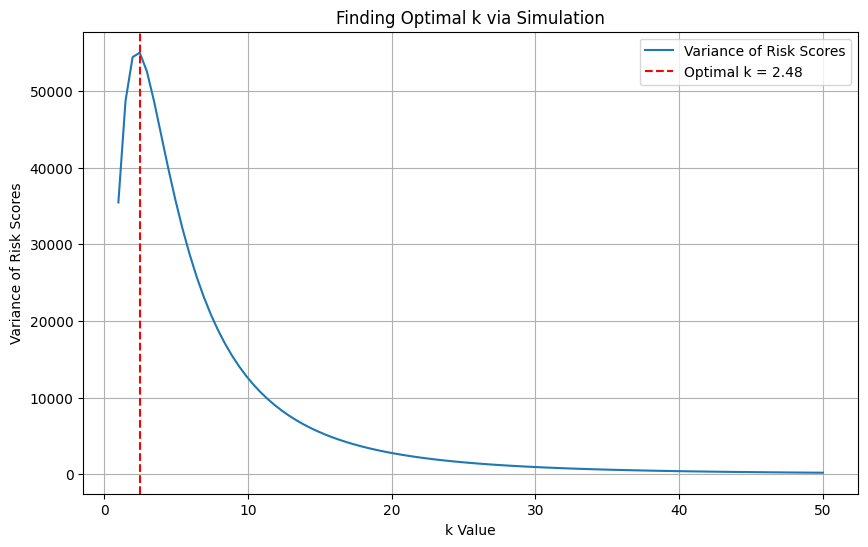

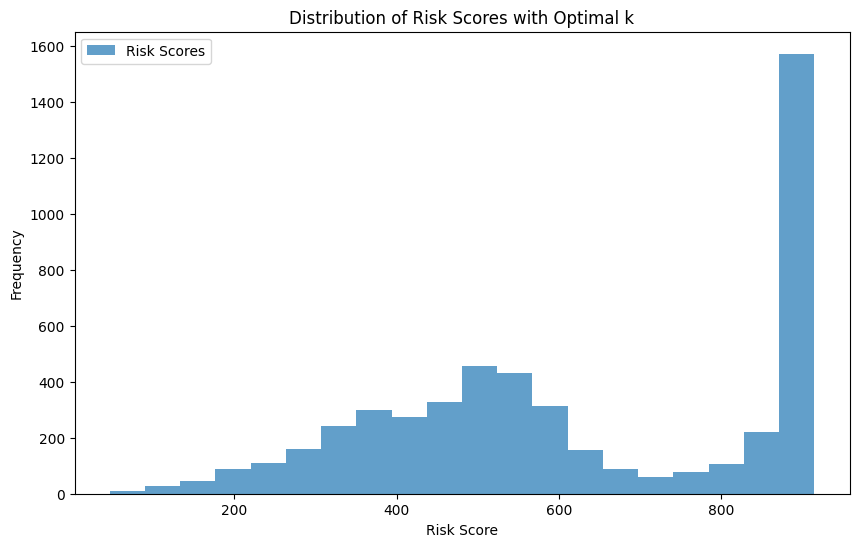

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Predicted probabilities from your model (replace with your actual probabilities)
predicted_probabilities = P1_all

# Define the risk score formula
def risk_score(P, k):
    return 1000 * (1 - np.exp(-k * P))

# Simulation: Test multiple k values
k_values = np.linspace(1, 50, 100)  # Range of k values to test
spread_variance = []  # Store ariance of risk scores for each k

# Calculate risk scores and variance for each k
for k in k_values:
    scores = risk_score(predicted_probabilities, k)
    spread_variance.append(np.var(scores))  # Measure variance of scores as an example criterion

# Find the best k by maximizing variance
optimal_k = k_values[np.argmax(spread_variance)]
print(f"effective k: {optimal_k}")

# Visualize k vs. score variance
plt.figure(figsize=(10, 6))
plt.plot(k_values, spread_variance, label='Variance of Risk Scores')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k:.2f}')
plt.xlabel('k Value')
plt.ylabel('Variance of Risk Scores')
plt.title('Finding Optimal k via Simulation')
plt.legend()
plt.grid()
plt.show()

# Generate final risk scores with optimal k
final_risk_scores = risk_score(predicted_probabilities, optimal_k)
plt.figure(figsize=(10, 6))
plt.hist(final_risk_scores, bins=20, alpha=0.7, label='Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.title('Distribution of Risk Scores with Optimal k')
plt.legend()
plt.show()


## Find cut off probability  and its risk score

Plot the ROC curve and identify the optimal cutoff using Youden's J statistic. it provides an optimal trade-off between sensitivity (true positive rate, TPR) and specificity (true negative rate). A higher J value means the threshold provides the best balance between minimizing false positives and false negatives, which is critical in risk-related scenarios like fraud detection or charge-off

In [11]:
from sklearn.metrics import roc_curve

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, P1_all)

# Calculate Youden's J statistic
youden_index = np.argmax(tpr - fpr)
optimal_probability = thresholds[youden_index]
optimal_risk_score = risk_score(optimal_probability, 2.48)

print(f"Optimal Cutoff Probability (ROC): {optimal_probability}")
print(f"Corresponding Risk Score: {optimal_risk_score}")


Optimal Cutoff Probability (ROC): 0.5615561877693019
Corresponding Risk Score: 751.586192735749


In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score

# Sample data (replace these with your actual values)
predicted_probs = P1_all
actual_y = y_train

# Create a DataFrame with predicted_probs and actual_y
results_df2 = pd.DataFrame({
    'predicted_probs': predicted_probs,
    'actual_y': actual_y
})

# Define the risk score calculation function
def risk_score(P, k):
    return 1000 * (1 - np.exp(-k * P))

# Add risk score column
k2 = 2.48
results_df2['risk_score'] = results_df2['predicted_probs'].apply(lambda x: risk_score(x, k2))

# Add classification column based on risk score
results_df2['classification'] = results_df2['risk_score'].apply(lambda x: 1 if x > 750 else 0)

# Calculate performance metrics
accuracy2 = accuracy_score(results_df2['actual_y'], results_df2['classification'])
precision2 = precision_score(results_df2['actual_y'], results_df2['classification'])
recall2 = recall_score(results_df2['actual_y'], results_df2['classification'])
mcc2 = matthews_corrcoef(results_df2['actual_y'], results_df2['classification'])
roc_auc2 = roc_auc_score(results_df2['actual_y'], results_df2['predicted_probs'])

# Display results
accuracy2, precision2, recall2, mcc2, roc_auc2


(0.8019333201814953,
 0.8899082568807339,
 0.6890292028413575,
 0.6198422347303171,
 0.8602387412842151)

# Probability method


In [13]:
import pandas as pd

predicted_probs = P1_all
actual_y = y_train

# Create a DataFrame with predicted_probs and actual_y
results_df = pd.DataFrame({
    'predicted_probs': predicted_probs,
    'actual_y': actual_y
})

results_df


,predicted_probs,actual_y
952,0.210938,0
2952,0.936618,1
1504,0.909866,1
7202,0.821964,1
2550,0.182237,0
...,...,...
3772,0.276136,0
5191,0.970706,1
5226,0.650523,1
5390,0.397488,1


In [14]:
def calculate_accuracy(df, cutoff):
    df['predicted_label'] = (df['predicted_probs'] > cutoff).astype(int)
    accuracy = (df['predicted_label'] == df['actual_y']).mean()  # Success probability
    return accuracy

# Loop through different cutoffs and store results
cutoffs = np.linspace(0.4, 0.6, 20)
accuracy_results = {}

for cutoff in cutoffs:
    accuracy_results[cutoff] = calculate_accuracy(results_df, cutoff)

accuracy_results

{0.4: 0.7966068258039061,
 0.4105263157894737: 0.7971986585125271,
 0.4210526315789474: 0.7979877687906884,
 0.43157894736842106: 0.7979877687906884,
 0.4421052631578948: 0.7981850463602288,
 0.45263157894736844: 0.7987768790688499,
 0.4631578947368421: 0.7983823239297692,
 0.4736842105263158: 0.7987768790688499,
 0.4842105263157895: 0.7991714342079306,
 0.49473684210526314: 0.8007496547642533,
 0.5052631578947369: 0.8007496547642533,
 0.5157894736842106: 0.8009469323337937,
 0.5263157894736842: 0.801144209903334,
 0.5368421052631579: 0.801144209903334,
 0.5473684210526315: 0.801144209903334,
 0.5578947368421052: 0.801736042611955,
 0.5684210526315789: 0.8013414874728744,
 0.5789473684210527: 0.800552377194713,
 0.5894736842105264: 0.7991714342079306,
 0.6: 0.7991714342079306}

In [15]:
import numpy as np

# Given success score
success_score = 751

# Define function to calculate k for each probability
def calculate_k(probability, target_score):
    # Rearranging the formula to solve for k
    k = -np.log(1 - target_score / 1000) / probability if probability > 0 else np.inf
    return k

calculate_k(0.55,success_score)


2.5278225136680534

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score

# Sample data (replace these with your actual values)
predicted_probs = P1_all
actual_y = y_train

# Create a DataFrame with predicted_probs and actual_y
results_df = pd.DataFrame({
    'predicted_probs': predicted_probs,
    'actual_y': actual_y
})

# Define the risk score calculation function
def risk_score(P, k):
    return 1000 * (1 - np.exp(-k * P))

# Add risk score column
k = 2.52
results_df['risk_score'] = results_df['predicted_probs'].apply(lambda x: risk_score(x, k))

# Add classification column based on risk score
results_df['classification'] = results_df['risk_score'].apply(lambda x: 1 if x > 751 else 0)

# Calculate performance metrics
accuracy = accuracy_score(results_df['actual_y'], results_df['classification'])
precision = precision_score(results_df['actual_y'], results_df['classification'])
recall = recall_score(results_df['actual_y'], results_df['classification'])
mcc = matthews_corrcoef(results_df['actual_y'], results_df['classification'])
roc_auc = roc_auc_score(results_df['actual_y'], results_df['predicted_probs'])

# Display results
accuracy, precision, recall, mcc, roc_auc


(0.8015387650424147,
 0.8886063072227874,
 0.6894238358326756,
 0.6188009045083279,
 0.8602387412842151)

## Results

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load your pre-processed dataset
preprocessed_data = pd.read_csv('/content/drive/MyDrive/ISC Case study/Data/pre_processed_dataset_balanced.csv')

# Assuming 'fico_score' is one of the columns and we are using the rest for features
Z = preprocessed_data.drop(columns=['fico_score'])  # Features
V = preprocessed_data['fico_score']  # FICO score

# Perform the train-test split
Z_train, Z_test, V_train, V_test = train_test_split(Z, V, test_size=0.3, random_state=42)

# Sample predicted probabilities from your model (P1_all from your logistic regression model)
predicted_probs = P1_all  # Replace with actual predicted probabilities from your model
actual_y = y_train  # Replace with actual labels (target variable)

# Define the risk score calculation function
def risk_score(P, k):
    return 1000 * (1 - np.exp(-k * P))

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Z_train_indices': Z_train.index,  # Indices of Z_train
    'fico_score_in_Z_train': preprocessed_data.loc[Z_train.index, 'fico_score'],  # FICO scores
    'actual_labels': actual_y  # Actual labels (from y_train)
})

# Classify based on FICO score: < 580 -> 1, else -> 0
results_df['fico_classification'] = results_df['fico_score_in_Z_train'].apply(lambda x: 1 if x < 580 else 0)

# Add predicted probabilities to the DataFrame (predicted_probs)
results_df['predicted_probs'] = predicted_probs

# Add risk score column using predicted probabilities
k2 = 2.30
results_df['risk_score'] = results_df['predicted_probs'].apply(lambda x: risk_score(x, k2))

# Classify based on risk score: > 750 -> 1, else -> 0
results_df['risk_classification'] = results_df['risk_score'].apply(lambda x: 1 if x > 750 else 0)
results_df


,Z_train_indices,fico_score_in_Z_train,actual_labels,fico_classification,predicted_probs,risk_score,risk_classification
952,952,711.000000,0,0,0.210938,384.400327,0
2952,2952,366.000000,1,1,0.936618,884.006462,1
1504,1504,362.000000,1,1,0.909866,876.645440,1
7202,7202,471.038864,1,1,0.821964,849.006242,1
2550,2550,644.000000,0,0,0.182237,342.390503,0
...,...,...,...,...,...,...,...
3772,3772,609.000000,0,0,0.276136,470.124715,0
5191,5191,480.559096,1,1,0.970706,892.753305,1
5226,5226,479.058452,1,1,0.650523,776.021195,1
5390,5390,695.745348,1,0,0.397488,599.171676,0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix

# FICO classifications vs actual labels
fico_accuracy = accuracy_score(results_df['actual_labels'], results_df['fico_classification'])
fico_precision = precision_score(results_df['actual_labels'], results_df['fico_classification'])
fico_recall = recall_score(results_df['actual_labels'], results_df['fico_classification'])
fico_f1 = f1_score(results_df['actual_labels'], results_df['fico_classification'])
fico_roc_auc = roc_auc_score(results_df['actual_labels'], results_df['fico_classification'])
fico_mcc = matthews_corrcoef(results_df['actual_labels'], results_df['fico_classification'])
fico_conf_matrix = confusion_matrix(results_df['actual_labels'], results_df['fico_classification'])

# Risk classifications vs actual labels
risk_accuracy = accuracy_score(results_df['actual_labels'], results_df['risk_classification'])
risk_precision = precision_score(results_df['actual_labels'], results_df['risk_classification'])
risk_recall = recall_score(results_df['actual_labels'], results_df['risk_classification'])
risk_f1 = f1_score(results_df['actual_labels'], results_df['risk_classification'])
risk_roc_auc = roc_auc_score(results_df['actual_labels'], results_df['risk_classification'])
risk_mcc = matthews_corrcoef(results_df['actual_labels'], results_df['risk_classification'])
risk_conf_matrix = confusion_matrix(results_df['actual_labels'], results_df['risk_classification'])

# Display the results
print("FICO Classification Metrics:")
print(f"Accuracy: {fico_accuracy:.4f}")
print(f"Precision: {fico_precision:.4f}")
print(f"Recall: {fico_recall:.4f}")
print(f"F1 Score: {fico_f1:.4f}")
print(f"ROC-AUC: {fico_roc_auc:.4f}")
print(f"MCC: {fico_mcc:.4f}")
print(f"Confusion Matrix:\n{fico_conf_matrix}")

print("\nRisk Classification Metrics:")
print(f"Accuracy: {risk_accuracy:.4f}")
print(f"Precision: {risk_precision:.4f}")
print(f"Recall: {risk_recall:.4f}")
print(f"F1 Score: {risk_f1:.4f}")
print(f"ROC-AUC: {risk_roc_auc:.4f}")
print(f"MCC: {risk_mcc:.4f}")
print(f"Confusion Matrix:\n{risk_conf_matrix}")


FICO Classification Metrics:
Accuracy: 0.7049
Precision: 0.7170
Recall: 0.6768
F1 Score: 0.6963
ROC-AUC: 0.7049
MCC: 0.4104
Confusion Matrix:
[[1858  677]
 [ 819 1715]]

Risk Classification Metrics:
Accuracy: 0.7992
Precision: 0.8964
Recall: 0.6764
F1 Score: 0.7710
ROC-AUC: 0.7991
MCC: 0.6172
Confusion Matrix:
[[2337  198]
 [ 820 1714]]


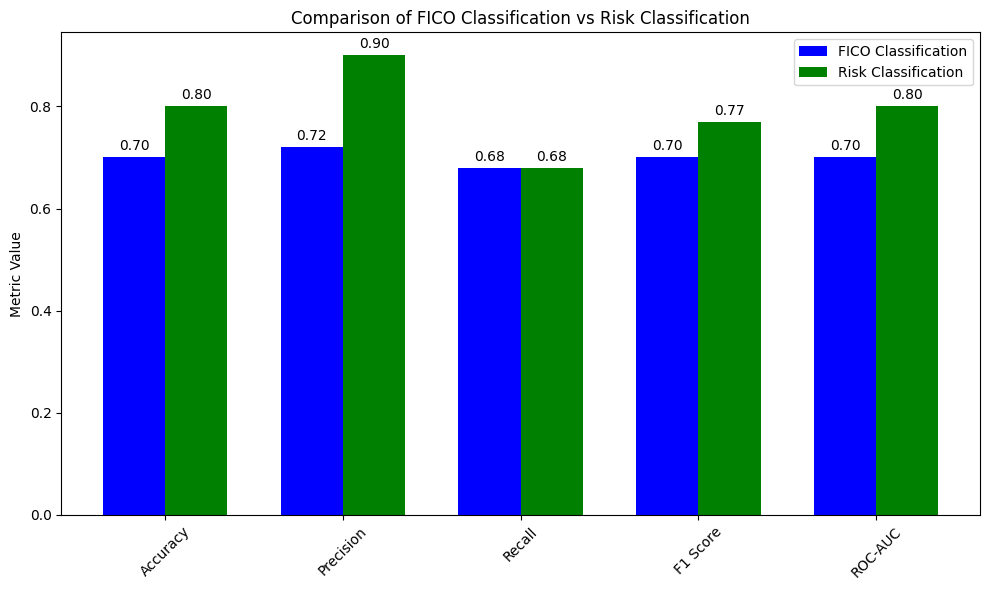

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with the actual metric values after calculating them
fico_metrics = {
    "Accuracy": 0.7049,
    "Precision": 0.7170,
    "Recall": 0.6768,
    "F1 Score": 0.6963,
    "ROC-AUC": 0.7049
}

risk_metrics = {
    "Accuracy": 0.7992,
    "Precision": 0.8964,
    "Recall": 0.6764,
    "F1 Score": 0.7710,
    "ROC-AUC": 0.7991
}

# Set up the labels and values
labels = list(fico_metrics.keys())
fico_values = [round(value, 2) for value in fico_metrics.values()]
risk_values = [round(value, 2) for value in risk_metrics.values()]

# Bar plot for metrics comparison
x = np.arange(len(labels))  # Label positions
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for FICO and Risk metrics
rects1 = ax.bar(x - width/2, fico_values, width, label='FICO Classification', color='blue')
rects2 = ax.bar(x + width/2, risk_values, width, label='Risk Classification', color='green')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of FICO Classification vs Risk Classification')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add values on top of bars
def add_values(rects, values):
    for rect, value in zip(rects, values):
        height = rect.get_height()
        ax.annotate(f'{value:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add values for both sets of bars
add_values(rects1, fico_values)
add_values(rects2, risk_values)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
